**DQN** (Deep Q-Networks, also called Deep Q-Learning, DQL), was a milestone in the Deep Reinforcement Learning (DRL) field, as it showed that it was possible to use the powerful approximation capabilities of Neural Networks to address complex dynamical environments. The original paper is: Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015). https://doi.org/10.1038/nature14236.

The main idea in DQN is to use a Neural Network to approximate the Q-value function, where:
* The input to the network is the current state $s_t$.
* The network has as many outputs as actions $a_1, a_2, ...., a_n$, since each output approximates the Q-value for the input state and that concrete action. That is, output $i$ of the network approximates $q(s_t,a_i)$.

Note that this means that, while **the state can be continuous and/or discrete, the actions can only be discrete**.

Remember the main points of DQN seen in class:
* There is a replay memory, where we store experience vectors $e_t = (s_t, a_t, r_t, d_t, s_{t+1})$, which are, respectively, the current state, the action taken, the reward received, a boolean flag indicating whether the state is terminal or not, and the next state. This experience memory allows increasing the sampling efficiency, as an experience vector can be used several times to update the network, and to break correlation among samples by randomly sampling batches of experience from the replay memory.
* There are two neural networks: a sampling network, and a target network, in order to provide further stability to the algorithm. The target network is updated less often, which can be done by using soft updates or by copying the sampling network weights every once in a while.

The algorithm works in two main phases:
* First, it interacts with the environment and adds experience vectors to the replay memory. In order to address the exploration-explotation tradeoff, an $\epsilon$-greedy policy is used, where the $\epsilon$ parameter (i.e., the amount of exploration) is decreased as the training progresses, so that the agent explores more at the beginning.
* Then, the neural networks are trained. The sampling network is updated by sampling a batch of data from the replay memory, and obtaining the following Bellman estimate:
$$
B_{\theta}(r_{t},s_{t+1})=\begin{cases}
r_{t} & \text{terminal }s_{t}\\
r_{t}+\gamma{\rm max}_{a'}q_{\theta_{tg}}\left(s_{t+1},a'\right) & \text{non-terminal }s_{t}
\end{cases}
$$
    * The sampling neural network weights ($\theta_{sa}$) are updated using a MSE criterion between the $q(s_t, a_i)$ predicted by the network and the Bellman term obtained for that $(s_t, a_i)$ pair.
    * The target network weights ($\theta_{tg}$) have to be updated less often, either by using soft updates, or by updating it every once in a while by copying the sampling network weights. The latter is the approach followed in this code.

Finally, DQN has fostered many variants, such as Dueling-DQN, DRQN (using Recurrent Neural Networks), PER (Prioritized Experience Replay), Double-DQN, Rainbow-DQN (that integrates several of the aforementioned methods), or C51 (a distributional implementation of DQN).

In this code, we are going to actually implement Double-DQN, whose only difference to DQN is that the Bellman term is computed in two steps:
* First, the optimal action is obtained from the sampling network:
$$
a^{*}=\arg{\rm max}_{a'}q_{\theta_{sa}}\left(s_{t+1},a'\right)
$$
* Then, the best value is obtained using the target network and the action obtained in the previous step:
$$
B_{\theta}(r_{t},s_{t+1})=r_{t}+\gamma q_{\theta_{tg}}\left(s_{t+1},a^{*}\right)
$$

Note that the main difference to DQN is that DQN selects the best action from the target network as well.

Let's start with the code! First, as usual, we import the main libraries we are going to use for this extremely simple version of DQN, applied to the Cartpole problem. We need to install the Gymnasium library, which implements the Cartpole.

In [2]:
!pip install gymnasium
import torch
import torch.nn as nn
from collections import deque
import numpy as np
import random
import gymnasium as gym
import matplotlib.pyplot as plt
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 6.2 MB/s eta 0:00:00


Next, we are going to create a simple MLP model to approximate the Q-value function. Note that the neural network is quite simple: depending on the problem to be addressed, it may suffice to use simple neural networks in DRL (and hence, it is possible to train using a CPU).

An important point to note is that the last layer will not have an activation when the model is created later, as we will use this MLP to approximate the Q-value function, whose domain, in general, is $\mathbb{R}$ (indeed, in our case is $\mathbb{R}^{+}$, so we may just as well have used a ReLU activation). If you have prior knowledge about the value function, you may encode it here, in the activation function.

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, final_activation=None, hidden_size=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)
        self.relu = nn.ReLU()
        self.final_activation = final_activation

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x


Next, we are going to define the agent. The methods implemented are:
* The **init** method sets up all parameters and initializes the two neural networks used: the sampling network (model) and the target network (target_model). Note that you can play around with the hyperparameters to see how they impact the convergence:
    * The discount factor controls how much the agent weights future rewards vs present rewards. As $\gamma \rightarrow 0$, the agent is myopic, but as $\gamma \rightarrow 1$ the agent becomes far-sighted.
    * The learning rate controls the optimizer used (ADAM in this case). A larger learning rate may bring a faster convergence, at the cost of worse learning stability (i.e., more variance).
    * Other parameters that you can adjust are: the exploration rate $\epsilon$, the batch size, and the size of the replay memory.
*   The **update_target_model** method copies the weights from the sampling network to the target network. It will be called once per episode, to ensure that the sampling network is updated more often than the target network.
* The **get_action** method implements the $\epsilon$-greedy policy: it is called every time that we need to get an action for a given state.
* The **append_sample** method is used to store experience vectors $e_t$ to the replay memory, and to decrease the exploration rate as the training progress.
* The **train_step** method performs a single update of the sampling network. It randomly samples a batch of data from the replay memory, obtains the Bellman term, and updates the weights of the sampling network, $\theta_{sa}$.
* The **train** method is the main method: it takes as input an environment, and proceeds to train the algorithm using the two phases mentioned before: it interacts with the environment and fills the replay memory, and then also updates the neural networks: every step, it updates the sampling network by calling the **train_step** method, and after each episode, it updates the target network by calling the **update_target_model** method. Note that this method is tailored to the Cartpole problem, as the convergence is achieved when a score higher than $490$ is achieved in the last $5$ iterations: if you want to use this code for other environment, you may want to change it.

In [4]:
class DDQNAgent:  # Double-DQN
    def __init__(self, state_size, action_size):
        # Define state and action space sizes
        self.state_size = state_size
        self.action_size = action_size
        # Hyper-parameters for the DQN architecture
        self.discount_factor = 0.99 # Discount factor for Bellman equation
        self.learning_rate = 0.001 # Learning rate for ADAM optimizer
        self.epsilon = 1.0 # Initial epsilon value (for epsilon greedy policy)
        self.epsilon_decay = 0.9995 # Epsilon decay (for epsilon greedy policy)
        self.epsilon_min = 0.01 # Minimal epsilon value (for epsilon greedy policy)
        self.batch_size = 64  # Batch size for replay
        self.train_start = 1000 # Adds a delay, for the memory to have data before starting the training
        # Create a replay memory using deque
        self.memory = deque(maxlen=2000)
        # create main model and target model
        self.model = MLP(self.state_size, self.action_size, hidden_size=24) # The main model is a MLP
        self.target_model = MLP(self.state_size, self.action_size, hidden_size=24) # The target model is a NN used to increase stability
        # Initialize target model
        self.update_target_model()
        # Define the optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    # Function to update the target model
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # Epsilon greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        else:
            q_value = self.model(torch.from_numpy(state)).detach().cpu().numpy()
            return np.argmax(q_value[0])

    # Save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
          self.epsilon = self.epsilon_min

    def train_step(self):
        if len(self.memory) < self.train_start:
            return -1 # Start training only when there are some samples in the memory (the -1 value is a flag for the loss)
        # Pick samples randomly from replay memory (with batch_size)
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)
        # Preprocess the batch by storing the data in different vectors
        states = np.zeros((batch_size, self.state_size))
        next_states = np.zeros((batch_size, self.state_size))
        actions = np.zeros((batch_size, 1))
        rewards = np.zeros((batch_size, 1))
        dones = np.zeros((batch_size, 1))

        for i in range(batch_size):
            states[i] = mini_batch[i][0]
            actions[i] = mini_batch[i][1]
            rewards[i] = mini_batch[i][2]
            next_states[i] = mini_batch[i][3]
            dones[i] = mini_batch[i][4]

        # Convert numpy arrays to torch tensors
        states = torch.Tensor(states)
        next_states = torch.Tensor(next_states)
        actions = torch.Tensor(actions).type(torch.LongTensor)
        rewards = torch.Tensor(rewards)
        dones = torch.Tensor(dones)

        # Obtain the targets for the NN training phase
        self.model.train()

        q = self.model(states) # q_sa(s,a)
        q_next = self.model(next_states) #q_sa(s',a)
        q_target = self.target_model(next_states) # q_tg(s',a)

        # Best actions (This is Double DQN)
        best_actions = torch.argmax(q_next, dim=1, keepdim=True)  # Select the best action using the sampling network
        # Obtain the Bellman term using the best_actions
        bellman_term = rewards + self.discount_factor * q_target.gather(1, best_actions) * (1 - dones)

        # Fit the model!
        loss = torch.mean(torch.square(bellman_term - q.gather(1, actions)))  # MSE loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.model.eval()  # Set the model back to evaluation mode

        return loss.item()

    def train(self, env, max_episodes=300, verbose=True, verbose_interval=10):

        scores, episodes, losses = [], [], []  # To store values for plotting
        break_flag = False  # To stop training when the agent has successfully learned

        for e in range(max_episodes):
            if break_flag:
                break
            done = False
            score = 0
            state, _ = env.reset(seed=np.random.randint(1000))  # Set the initial state
            state = np.reshape(state, [1, self.state_size])
            l = []  # To store the loss values of the episode

            while not done:  # Iterate while the game has not finished
                # Get action for the current state and go one step in environment
                action = self.get_action(state)  # Using epsilon-greedy policy
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                next_state = np.reshape(next_state, [1, self.state_size])

                # Save the sample <s, a, r, s'> to the replay memory
                self.append_sample(state, action, reward, next_state, done)
                # Train
                loss = self.train_step()

                score += reward
                state = next_state
                l.append(loss)

                if done:

                    # Update target model after each episode
                    self.update_target_model()
                    # Store values for plotting
                    scores.append(score)
                    episodes.append(e)
                    losses.append(np.mean(l))
                    # Output the results of the episode
                    if verbose and e % verbose_interval == 0:
                        print("episode:", e, "  score:", score, "  memory length:",
                              len(agent.memory), "loss:", losses[-1], " epsilon:", agent.epsilon)

                    # Stop if mean scores of last 5 episodes is higher than 490
                    if np.mean(scores[-min(5, len(scores)):]) > 490:
                        break_flag = True

        # Output whether the agent learnt or not
        if break_flag:
            print("Training finished successfully")
        else:
            print("Training finished unsuccessfully")

        return episodes, scores, losses


Let us now describe the environment where we are going to train our agent: the Cartpole problem. We have a moving cart with a pole and a mass on top, and want to keep the pole vertical.

* The state set is continuous and has 4 components: pole angle and angular speed, and cart position and velocity.

* The action set is $A=\left[LF,RF\right]$ and are the forces applied to the cart pole, where $LF$ is a left force and $RF$ is a right force.

* The rewards are $+1$ for every time step that the pole has not fallen: if the pole surpasses a certain angle (i.e., it falls), the episode terminates.

We use the Gymnasium library, which contains many environments implemented for DRL.

The CartPole environment allows up to 500 time steps. That is the maximum time of play. This time could be increased with env._max_episode_steps, but we use 500 for demonstration purposes.

In [5]:
env = gym.make('CartPole-v1')

A known problem of DRL are the reproducibility issues (see Henderson, P., Islam, R., Bachman, P., Pineau, J., Precup, D., & Meger, D. (2018, April). Deep reinforcement learning that matters. In Proceedings of the AAAI conference on artificial intelligence (Vol. 32, No. 1), https://doi.org/10.48550/arXiv.1709.06560).

To prevent that, the code is seeded: note that changing the seed will change the results, as DRL is known to be extremely sensitive to the initial conditions.

In [6]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

We are finally ready! Now, we can train our agent and see what they learn. In order to show the differences between seeds, we are going to run $3$ different initial seeds: note how they have very different convergence properties, in spite of the fact that all hyperparameters are the same, except for the seed!

In [7]:
trials = 3
episodes, scores, losses = [], [], []

for i in range(trials):
    print("Trial {}/{}".format(i + 1, trials))
    # Create the agent
    agent = DDQNAgent(env.observation_space.shape[0], env.action_space.n)
    # Train the agent
    e, s, l = agent.train(env, max_episodes=300, verbose=True, verbose_interval=10)
    episodes.append(e)
    scores.append(s)
    losses.append(l)

Trial 1/3
episode: 0   score: 21.0   memory length: 21 loss: -1.0  epsilon: 0.9895523341234285
episode: 10   score: 25.0   memory length: 242 loss: -1.0  epsilon: 0.8860071485337379
episode: 20   score: 22.0   memory length: 459 loss: -1.0  epsilon: 0.7948853455740398
episode: 30   score: 14.0   memory length: 626 loss: -1.0  epsilon: 0.7311926754228393
episode: 40   score: 14.0   memory length: 819 loss: -1.0  epsilon: 0.6639141638728693
episode: 50   score: 18.0   memory length: 981 loss: -1.0  epsilon: 0.6122450513621789
episode: 60   score: 22.0   memory length: 1175 loss: 1.4327160688963803  epsilon: 0.5556331948276143
episode: 70   score: 15.0   memory length: 1304 loss: 6.761828438440959  epsilon: 0.5209177837656779
episode: 80   score: 17.0   memory length: 1450 loss: 6.002264629392063  epsilon: 0.4842367638152614
episode: 90   score: 68.0   memory length: 1852 loss: 6.507427165613455  epsilon: 0.3960433606244756
episode: 100   score: 114.0   memory length: 2000 loss: 6.0936624

Now, we plot the results: note that some seeds learn, and others do not, just because of the seed. Thus, it is good practice in DRL to run an algorithm several times, over 8-10 seeds, and then average the results of the best 3-5 seeds.

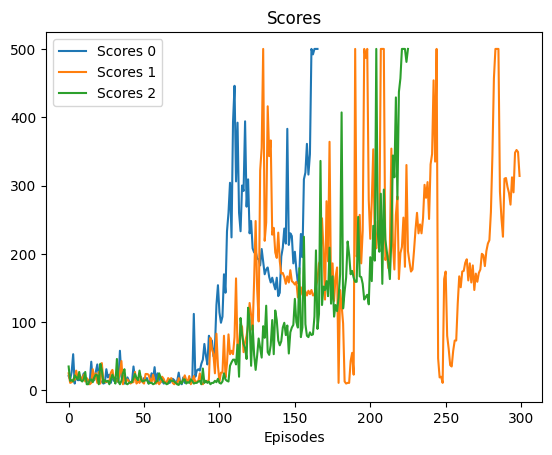

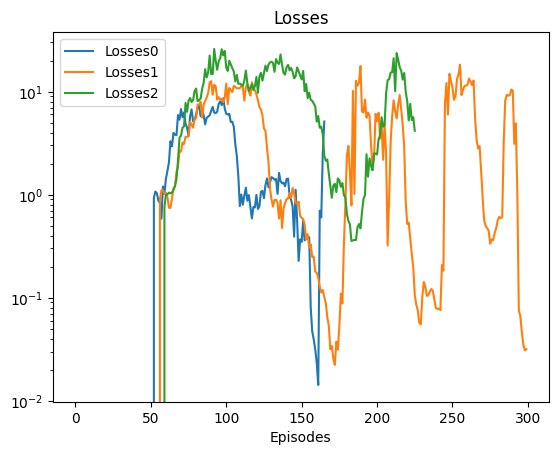

In [8]:
# Plot the scores and losses vs the episodes
fig, ax1 = plt.subplots()

for i in range(trials):
    ax1.plot(episodes[i], scores[i], label='Scores ' + str(i))

ax1.set_xlabel('Episodes')
plt.legend(loc='best')
plt.title('Scores')
plt.show()

# Plot the losses
fig, ax1 = plt.subplots()

for i in range(trials):
    ax1.semilogy(episodes[i], losses[i], label='Losses' + str(i))

ax1.set_xlabel('Episodes')
plt.legend(loc='best')
plt.title('Losses')
plt.show()

Finally, we will visualize the learned policy. Note that we set the exploration parameter to $0$, so that the agent does not explore.

Obtaining data from trained network
Data obtained
Creating animation


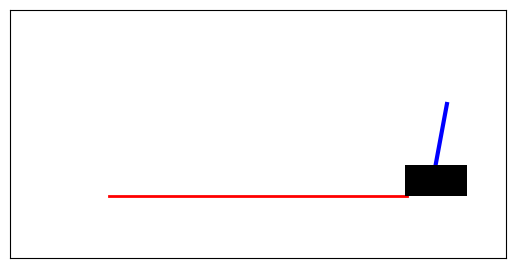

In [10]:
# Run the game once with the trained network and store the values of the position and angle of the cartpole
print("Obtaining data from trained network")
pos_vector=[]
angle_vector=[]
state, _ = env.reset()
state = np.reshape(state, [1, agent.state_size])
agent.epsilon = 0  # So that the agent does not explore, only exploits
done=False
while not done:
    pos_vector.append(state[0,0])
    angle_vector.append(state[0,2])
    action = agent.get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    next_state = np.reshape(next_state, [1, agent.state_size])
    state = next_state
    if done:
        break
T=len(pos_vector)
print("Data obtained")

# Animate the data: to observe what our network has learned
from matplotlib import animation, patches
from IPython.display import HTML
print("Creating animation")
fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-1, 3), aspect=1)
ax.set_xticks([])
ax.set_yticks([])

mag1 = plt.Rectangle((0,0), width= 1, height= 0.5, angle=0, fc='black', alpha=0)
line1, = ax.plot([], [], 'b', zorder=1,linewidth=3.0)
line2, = ax.plot([], [], 'r', zorder=1,linewidth=2.0)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    ax.add_patch(mag1)
    return mag1, line1, line2,

def animate(i):
    mag1.set_alpha(1)
    mag1.xy = (pos_vector[i],0)
    x0=pos_vector[i]+0.5
    y0=0.5
    x1=x0+np.cos(np.pi/2-angle_vector[i])
    y1=y0+np.sin(np.pi/2-angle_vector[i])
    line1.set_data([x0, x1], [y0, y1])
    line2.set_data([-2.4, 2.4], [0,0])
    return mag1, line1, line2,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=T,
                               interval=25, blit=True)

HTML(anim.to_jshtml())